# PneumoGuard

#### Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

#### Loading the dataset

In [2]:
model_name = 'PneumoGuard'
path = f'Mask/'
train_path = path + 'train/'
test_path = path + 'test/'
valid_path = path + 'valid/'

input_shape = (224, 224, 3)
target_size = (224, 224)
classes = 2

#### Initializing the train image generator

In [3]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  
)

Found 5233 images belonging to 2 classes.


#### Initializing the validation image generator

In [4]:
valid_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
)

Found 624 images belonging to 2 classes.


#### Initializing the test image generator

In [5]:
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
)

Found 624 images belonging to 2 classes.


#### Initializing the model

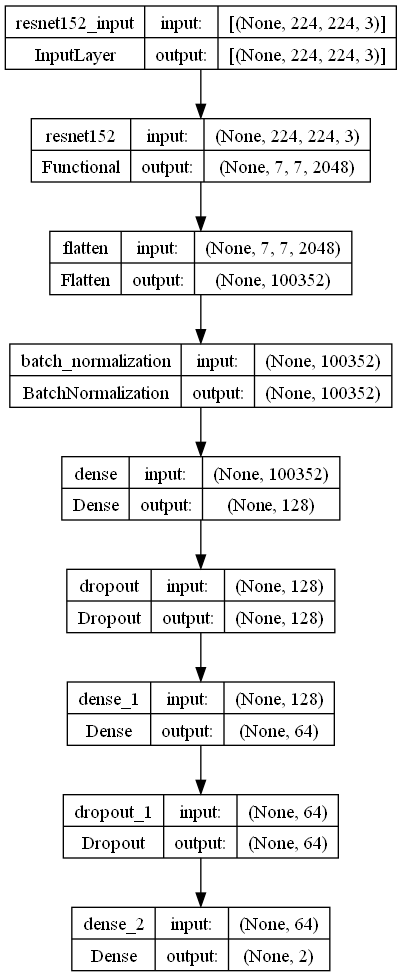

In [6]:
base_model = ResNet152(include_top=False, pooling='av', weights='imagenet', input_shape=(input_shape))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='sigmoid'))
plot_model(model, to_file=f"Images/{model_name}_architecture.png", show_shapes=True, show_layer_names=True)

#### Initializing the optimizer

In [7]:
optimizer = Adam()

#### Compiling the model

In [8]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath=f'{model_name}.h5',
    monitor='loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)

#### Training the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 2.5256 - accuracy: 0.8490
Epoch 1: loss improved from inf to 2.52562, saving model to PneumoGuard.h5
164/164 [==============================] - 83s 456ms/step - loss: 2.5256 - accuracy: 0.8490 - val_loss: 0.8304 - val_accuracy: 0.8654
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 1.1419 - accuracy: 0.8662
Epoch 2: loss improved from 2.52562 to 1.14191, saving model to PneumoGuard.h5
164/164 [==============================] - 72s 441ms/step - loss: 1.1419 - accuracy: 0.8662 - val_loss: 0.3610 - val_accuracy: 0.8590
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.8636
Epoch 3: loss improved from 1.14191 to 0.58179, saving model to PneumoGuard.h5
164/164 [==============================] - 70s 427ms/step - loss: 0.5818 - accuracy: 0.8636 - val_loss: 0.3347 - val_accuracy: 0.8686
Epoch 4/100
164/164 [==============================] - ETA: 0s - loss: 0.4

#### Evaluating the model

In [ ]:
result = model.evaluate(test_generator)

#### Plotting the accuracy and loss

In [ ]:
metrics = ["accuracy", "loss"]
for metric in metrics:
    plt.clf()
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='val')
    plt.legend(loc="right")
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.title(f"{model_name} {metric.capitalize()}")
    plt.savefig(f'Images/{model_name}_{metric}.png')